In [18]:
%load_ext autoreload
%autoreload 2

from IPython.display import Math, Latex

import pandas as pd, cvxpy as cp, numpy as np, matplotlib as mpl  # type: ignore
import matplotlib.pyplot as plt  # type: ignore

from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
from matplotlib.patches import FancyArrowPatch, Polygon  # type: ignore
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

from scipy.integrate import quad  # type: ignore
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d

import importlib, itertools, csv, concurrent.futures
import os, math, sys, json, pickle, shutil, time, functools

from typing import Dict, List, Any, Optional, Literal
from tqdm.notebook import tqdm

from Utils import Notebook, tex, gph, sgn, nm, ds
from petc_simulation import closed_loop_aetm, open_loop
from optimization import DisturbedSaturatedPETC as DSPETC

cfg = {
    'style': {'color': 'black'},
    'axis': {
        'title_pad': 10,
        'x_label_fontsize': 16,
        'y_label_fontsize': 16,
        'tick_fontsize': 16,
    },
    'legend': {'fontsize': 16}
}

colors_list = plt.get_cmap('tab20').colors
Notebook.setup()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


LaTeX has been enabled for text rendering.


### Definição da Planta

In [19]:
experiment_config_filename = 'experiment-2'

with open(f"experiment/{experiment_config_filename}.json", encoding='utf-8') as f:
  config = json.load(f)

sim_duration = config['simulation_duration']
sim_step = config.get("simulation_step", 1e-4)
timepts = np.arange(0, sim_duration + sim_step, sim_step)

plant = ds.StateSpace(data=config["plant"], name='plant')
latex_expr = plant.get_latex_equations()
print("Equações que regem a dinâmica da planta:")
tex.display_latex(latex_expr)

Equações que regem a dinâmica da planta:


<IPython.core.display.Latex object>

### Simulação da Planta em Malha Aberta

In [20]:
%%skip

x0 = np.array([[1.0], [-1.0]], dtype=np.float32)
plant_output, time_history, signal_control, _, _ = open_loop(
    x0, config, u_constant=0.0)

Cell skipped (unconditional).


In [21]:
%%skip

fig = plt.figure(figsize=(8, 3), layout='constrained')
axs = fig.subplot_mosaic([["x"]])

y = plant_output
t = time_history

x_norm = np.linalg.norm(y, axis=0)
xnorm_f, xnorm_ul = nm.format_magnitudes(x_norm)

_ = gph.plot(
    axs['x'], t, x_norm,
    xlabel='$t$', x_unit='s',  x_use_prefixes=True,
    ylabel=r'$\|x(t)\|$',
    cfg={**cfg,
         'axis': {**cfg['axis']},
         'limits': {'x_min': 0, 'x_max': t[-1]}, }
)

Cell skipped (unconditional).


### Projeto do Controlador e do ETM

In [22]:
plant_data = {
    'nx': plant.nx, 'nu': plant.nu, 'nρ': plant.n_rho, 'nw': plant.nw, 'nz': plant.nz,
    'ρ_bounds': plant.get_parameter_bounds(),
    'u_bar': plant.get_input_bounds()[0],
    'matrices_func': lambda ρi: plant.matrices_func(ρi),
}

design_params = config["design_params"]["dspetc"]
design_params["δ"] = 1. / (plant.get_disturbance_l2_norm_bound())
should_save = design_params.get("save", True)

try:
  simulation_id = ds.create_simulation_id(plant, design_params, "AETM")
  print(f"Unique Simulation ID: {simulation_id}")
  results_dir = f"./results/{simulation_id}"
except (NameError, ValueError) as e:
  print(f"Error generating simulation ID: {e}")
  simulation_id = "sim_default"
  results_dir = "./results/sim_default"

results_file_path = os.path.join(results_dir, "results_data.pkl")
results = None

try:
  if not should_save:
    print("Save flag is False. Cache will be ignored.")
    results = DSPETC.aetm_synthesis(
        plant_data, design_params, eps=1e-5, dtype=np.float64)

  else:
    print(f"Using cache file: {results_file_path}")

    if os.path.exists(results_file_path):
      try:
        with open(results_file_path, 'rb') as f:
          results = pickle.load(f)
        print("Cache successfully loaded.")
      except Exception as e:
        print(f"Failed to load cache: {e}")
        results = None

    if results is None:
      print("Running solver (fresh computation)...")
      results = DSPETC.aetm_synthesis(
          plant_data, design_params, eps=1e-5, dtype=np.float64)

      if results is not None:
        try:
          os.makedirs(results_dir, exist_ok=True)
          with open(results_file_path, 'wb') as f:
            pickle.dump(results, f)
          print("Results saved to cache.")
        except Exception as e:
          print(f"Failed to save results: {e}")

  Ξ = Ψ = K = L1 = P = γ = β = None
  Θ, λ = None, None
  optimal_value = None
  δinv = plant.get_disturbance_l2_norm_bound()

  if results is not None:
    Ξ, σ = results['etm']['Ξ'], design_params['σ']
    K, L1, L2 = results['controller']['K'], results['controller']['L1'], results['controller']['L2']
    P, S2 = results['lyapunov']
    γ, β = results['bounds']
    optimal_value = results['optimal_value']

    print(f'σ = {σ:.3e}, γ = {γ:.3e}, Induced gain = {np.sqrt(1. / γ):.3e}')
    display(Math(rf'\Xi = {tex.mat2tex(Ξ)}'))
    display(Math(rf'P = {tex.mat2tex(P)}'))

    for i in nm.binary_set(plant.n_rho):
      display(Math(rf'K_{{{i}}} = {tex.mat2tex(K[i])}'))
      display(Math(rf'L_{{{i}}} = {tex.mat2tex(L1[i])}'))

  else:
    print('Problem is infeasible or failed to load/compute results.')
    if should_save and os.path.exists(results_dir):
      shutil.rmtree(results_dir)
      print(f"Results directory removed: {results_dir}")

except Exception as e:
  print(f"Unexpected error during execution or processing: {e}")
  if should_save and os.path.exists(results_dir):
    try:
      shutil.rmtree(results_dir)
      print(f"Results directory removed after error: {results_dir}")
    except Exception as cleanup_e:
      print(f"Failed to remove results directory: {cleanup_e}")

Unique Simulation ID: sim_09834a7b8331319bb7012d11d0c78464
Using cache file: ./results/sim_09834a7b8331319bb7012d11d0c78464\results_data.pkl
Running solver (fresh computation)...
Results saved to cache.
σ = 1.000e-02, γ = 1.564e+00, Induced gain = 7.997e-01


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Regiões

In [23]:
def plot_regions_comparison(plant, nm, gph, K, L1, P, δinv, γ, trajectories=None, zoom_only=False):
  """Plot 2D regions in state-space, with optional zoom-only mode and trajectories overlay.

  Parameters
  ----------
  plant : object
      Plant model containing bounds and parameters.
  nm : object
      Numerical model utilities (ellipsoid, binary sets, etc.).
  gph : object
      Graph/plot helper with polygon and legend utilities.
  K, L1 : dict
      Controller gain and auxiliary matrices.
  P : np.ndarray
      Lyapunov matrix defining the ellipsoidal regions.
  δinv : float
      Inverse delta parameter for enlarged region.
  γ : float
      Scaling factor.
  trajectories : list of np.ndarray, optional
      List of trajectories to plot, each of shape (N, 2).
  zoom_only : bool, optional
      If True, plot only the zoomed region and overlay trajectories.
  """

  num_points = 20
  B2 = nm.binary_set(plant.n_rho)
  u_bar = plant.get_input_bounds()
  X0 = nm.ellipsoid_boundary_points(P, 1, num_points)
  D0 = nm.get_ellipsoid_boundary(P, 1)
  Dx = nm.get_ellipsoid_boundary(P, 1 + δinv / γ)

  if len(B2) != 2:
    print(f"Warning: Expected len(B2) == 2 but got {len(B2)}.")

  b1, b2 = B2[:2]

  def parallelogram_vertices(H1, H2):
    return gph.get_parallelogram2D_vertices(H1, H2, u_bar)[0]

  du_poly = parallelogram_vertices(K[b1] - L1[b1], K[b2] - L1[b2])
  du_tilde_poly = parallelogram_vertices(K[b1], K[b2])

  def compute_limits(x_data, y_data, padding_ratio=0.1):
    min_x, max_x = np.min(x_data), np.max(x_data)
    min_y, max_y = np.min(y_data), np.max(y_data)
    pad_x = (max_x - min_x) * padding_ratio
    pad_y = (max_y - min_y) * padding_ratio
    return (min_x - pad_x, max_x + pad_x), (min_y - pad_y, max_y + pad_y)

  all_x_ax1 = np.concatenate(
      [X0[0], D0['x1_vals'], Dx['x1_vals'], du_poly[:, 0]])
  all_y_ax1 = np.concatenate(
      [X0[1], D0['x2_vals'], Dx['x2_vals'], du_poly[:, 1]])
  x1_range_ax1, x2_range_ax1 = compute_limits(all_x_ax1, all_y_ax1)

  all_x_ax2 = np.concatenate([D0['x1_vals'], Dx['x1_vals']])
  all_y_ax2 = np.concatenate([D0['x2_vals'], Dx['x2_vals']])
  x1_range_ax2, x2_range_ax2 = compute_limits(all_x_ax2, all_y_ax2)

  def draw_region(ax, zoom=False):
    ax.add_patch(Polygon(du_tilde_poly, closed=True,
                         edgecolor='#d0d0d0', facecolor='white',
                         linestyle=':', linewidth=2.0, zorder=1))
    ax.add_patch(Polygon(du_poly, closed=True,
                         edgecolor='#084475', fill=False,
                         linewidth=1.5, zorder=2))

    ax.plot(X0[0], X0[1], '*', c='black', markersize=12, zorder=3)
    ax.plot(D0['x1_vals'], D0['x2_vals'], 'k-', zorder=3)
    ax.plot(Dx['x1_vals'], Dx['x2_vals'], 'k--', zorder=3)

    # Optional trajectories
    if trajectories is not None:
      for traj in trajectories:
        ax.plot(traj[:, 0], traj[:, 1], '-',
                linewidth=1.8, alpha=0.8, zorder=4)

    ax.set_xlabel("$x_1$", fontsize=20)
    ax.set_ylabel("$x_2$", fontsize=20)
    ax.tick_params(axis='both', labelsize=16)
    ax.set_facecolor('#f5f5f5')
    ax.grid(True, zorder=0)

    if zoom:
      ax.set_xlim(x1_range_ax2)
      ax.set_ylim(x2_range_ax2)
    else:
      ax.set_xlim(x1_range_ax1)
      ax.set_ylim(x2_range_ax1)

    elements = [
        ('line', {'color': '#084475', 'linestyle': '-', 'linewidth': 2.0}),
        ('line', {'color': '#d0d0d0', 'linestyle': ':', 'linewidth': 2.0}),
        ('line', {'color': 'black', 'linestyle': '--', 'linewidth': 2.}),
        ('line', {'color': 'black', 'linestyle': '-', 'linewidth': 2.}),
        ('marker', {'marker': '*', 'color': 'black', 'markersize': 10})
    ]
    labels = [r'$\mathscr{D}_u$', r'$\tilde{\mathscr{D}}_u$',
              r'$\mathscr{D}_x$', r'$\mathscr{D}_0$', '$x_0$']
    gph.create_custom_legend(ax, elements, labels)

  # --- Rendering ---
  if zoom_only:
    fig, ax = plt.subplots(figsize=(6., 6.))
    draw_region(ax, zoom=True)
  else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12., 6.))
    draw_region(ax1, zoom=False)
    draw_region(ax2, zoom=True)

  plt.tight_layout()
  return fig

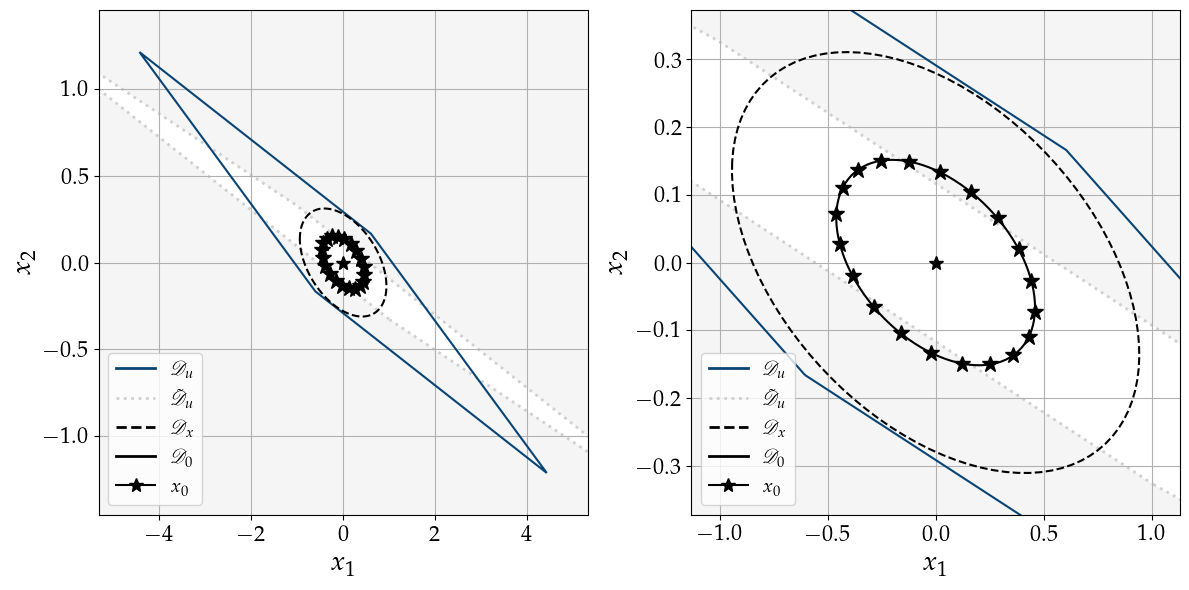

In [24]:
%%skip plant.nx != 2

plot_regions_comparison(plant, nm, gph, K, L1, P, δinv, γ)

### Simulação do Sistema em Malha Fechada

In [25]:
FORCE_RECALCULATE = True
SAVE_TO_CACHE = True
NUM_POINTS = 1
MAX_WORKERS = 15
indices_to_run = list(range(NUM_POINTS))
all_results = []

try:
  if 'config' not in globals() or 'results' not in globals():
    raise NameError(
        "Variables 'config' or 'results' not found. Please execute cells [3] and [7] first."
    )

  simulation_id = ds.create_simulation_id(
      plant, config["design_params"]["dspetc"], "SETM_STAR"
  )
  results_dir = f"./Results/{simulation_id}"
  trajectories_cache_file = os.path.join(
      results_dir, "trajectories_cache.pkl")
  abs_trajectories_path = os.path.abspath(trajectories_cache_file)

  if os.path.exists(abs_trajectories_path) and not FORCE_RECALCULATE:
    print(
        f"Loading {NUM_POINTS} trajectories from cache: {abs_trajectories_path}")
    with tqdm(total=1, desc="Reading cache") as pbar:
      with open(abs_trajectories_path, 'rb') as f:
        all_results = pickle.load(f)
      pbar.update(1)
    print("Cache successfully loaded.")

  else:
    print(
        f"Starting {NUM_POINTS} simulations... "
        f"(force_recalculate_trajectories={FORCE_RECALCULATE})"
    )
    start_time = time.time()

    P = results['lyapunov'][0]
    X0_matrix = ds.ellipsoid_boundary_points(P, 1, NUM_POINTS)

    x0_inputs = [
        X0_matrix[:, i].reshape(-1, 1).astype(np.float32)
        for i in range(NUM_POINTS)
    ]

    run_sim_partial = functools.partial(
        closed_loop_aetm, config=config, results=results)

    if __name__ == "__main__":
      with concurrent.futures.ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
        print(
            f"Running simulations (max {MAX_WORKERS} workers in parallel)...")

        results_iter = executor.map(run_sim_partial, x0_inputs)

        for idx, result in tqdm(enumerate(results_iter), total=NUM_POINTS, desc="Simulations"):
          try:
            if isinstance(result[0], str) and "Erro" in result[0]:
              print(
                  f"\nSimulation (idx {idx}) failed: {result[0]}")
            else:
              all_results.append((idx,) + result)
          except Exception as e:
            print(f"\nException raised during pool execution: {e}")

    end_time = time.time()
    print("---")
    print(
        f"Parallel processing completed in {end_time - start_time:.2f} seconds.")

    if len(all_results) == NUM_POINTS:
      if SAVE_TO_CACHE:
        print(
            f"Saving {NUM_POINTS} trajectories to cache: {abs_trajectories_path}")
        all_results.sort(key=lambda x: x[0])
        os.makedirs(results_dir, exist_ok=True)
        with tqdm(total=1, desc="Saving cache") as pbar:
          with open(abs_trajectories_path, 'wb') as f:
            pickle.dump(all_results, f)
          pbar.update(1)
      else:
        print("Cache saving skipped (SAVE_TO_CACHE=False).")
    else:
      print(
          f"ERROR: Some simulations failed ({len(all_results)}/{NUM_POINTS}). "
          "Cache will not be saved."
      )

except Exception as e:
  print(f"An error occurred while setting up cache or process pool: {e}")
  import traceback
  traceback.print_exc()

all_results.sort(key=lambda x: x[0])
print(f"\nTotal number of ready results: {len(all_results)}")

Starting 1 simulations... (force_recalculate_trajectories=True)
Running simulations (max 15 workers in parallel)...


Simulations:   0%|          | 0/1 [00:00<?, ?it/s]

---
Parallel processing completed in 105.37 seconds.
Saving 1 trajectories to cache: p:\Notebooks\Event-Based-Control\PETC for LPV Systems\Results\sim_8a36928030e834c228daedb3cba120f2\trajectories_cache.pkl


Saving cache:   0%|          | 0/1 [00:00<?, ?it/s]


Total number of ready results: 1


In [26]:
index_to_plot = 0

if 'all_results' in globals() and len(all_results) > 0:
  if 0 <= index_to_plot < len(all_results):
    print(f"Preparing data for plotting (index = {index_to_plot})...")

    selected_result = next(
        (res for res in all_results if res[0] == index_to_plot), None
    )

    if selected_result is not None:
      idx, y_data, t_data, control_signal, σ_data, event_times = selected_result

      y = y_data
      t = t_data

      inter_event_time = DSPETC.get_iet(event_times)

      std_iet = np.std(inter_event_time)
      cv_iet = std_iet / np.mean(inter_event_time)
      event_rate = len(inter_event_time) / timepts[-1]

      print(
          "Variables 'y', 't', 'control_signal', and 'event_times' have been updated.")

      print("Estado Inicial: ", y[0].reshape(-1))
      print("Número de amostras dos estados: ", int(t[-1] / 0.1e-3))
      print("Número de transmissões de estados realizados: ",
            len(inter_event_time))
      print("Menor IET Obtido: ", min(inter_event_time))
      print("Máximo IET Obtido: ", max(inter_event_time))
      print("Média do Intervalos de Tempo entre Eventos: ", np.mean(
            inter_event_time))

      print("Desvio-padrão dos IETs: ", std_iet)
      print("Coeficiente de variação dos IETs: ", cv_iet)
      print("Taxa média de acionamentos: ", event_rate, "eventos/s")
    else:
      print(f"Error: No result found for index = {index_to_plot}.")
  else:
    print(
        f"Error: 'index_to_plot' must be between 0 and {len(all_results) - 1}.")
else:
  print("Error: 'all_results' not found. Please run the parallel simulation cell first.")

Preparing data for plotting (index = 0)...
Variables 'y', 't', 'control_signal', and 'event_times' have been updated.
Estado Inicial:  [-0.45990452 -0.45989728 -0.45989004 ...  0.00059005  0.00059004
  0.00059002]
Número de amostras dos estados:  200000
Número de transmissões de estados realizados:  134
Menor IET Obtido:  0.0
Máximo IET Obtido:  0.56670094
Média do Intervalos de Tempo entre Eventos:  0.14814255
Desvio-padrão dos IETs:  0.15082948
Coeficiente de variação dos IETs:  1.0181375
Taxa média de acionamentos:  6.7 eventos/s


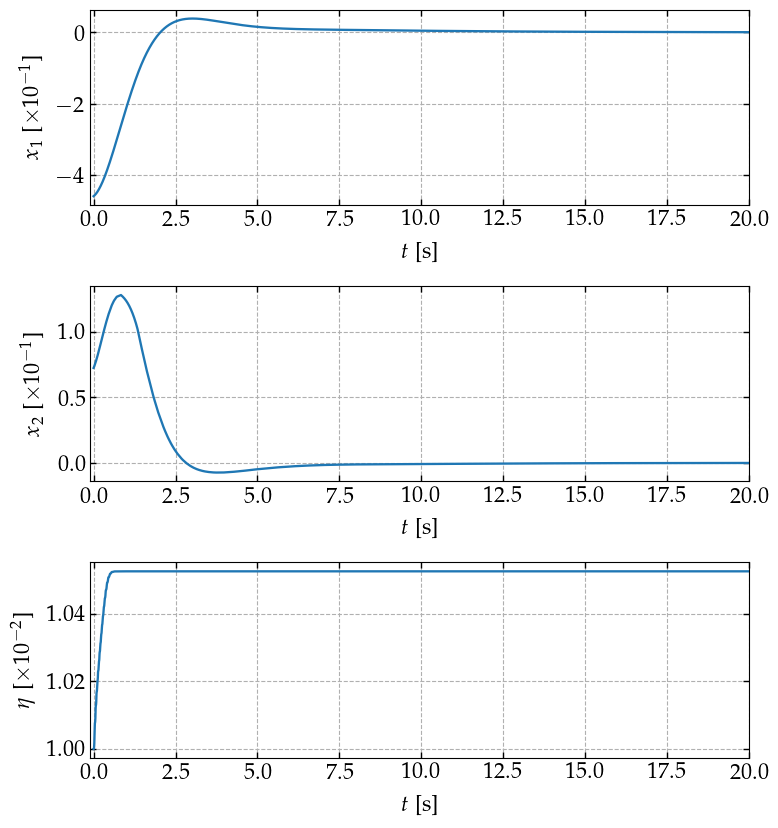

In [27]:
stacked_layout = True

base_height = 6
fig_height = base_height if not stacked_layout else base_height + \
    2.5 * (plant.nx - 1)

mosaic = [['x'], ['σ']]
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8, fig_height))

fy = nm.format_magnitudes(y.flatten(), '', False, return_order=True)
scaled_y, y_label, y_order = fy
prev_fmt = (None, (scaled_y, y_label, y_order))

if stacked_layout:
  from matplotlib.gridspec import GridSpec

  axs['x'].remove()
  axs['σ'].remove()

  total_rows = plant.nx + 1
  gs = GridSpec(total_rows, 1, figure=fig, height_ratios=[1] * total_rows)

  axs_x = []
  for i in range(plant.nx):
    axs_x.append(fig.add_subplot(
        gs[i, 0], sharex=axs_x[0] if i > 0 else None))

  ax_eta = fig.add_subplot(gs[-1, 0], sharex=axs_x[0])

  for i, ax in enumerate(axs_x):
    gph.plot(
        ax, t, y[i],
        xlabel='$t$',
        x_unit='s',
        x_use_prefixes=True,
        ylabel=fr'$x_{i+1}$',
        cfg={**cfg, 'style': {'color': colors_list[0]}},
        x_pad=(0.005, 0.0), y_pad=(0.05, 0.05)
    )

  axs['σ'] = ax_eta

else:
  for i in range(plant.nx):
    gph.plot(
        axs['x'], t, y[i],
        xlabel='$t$', x_unit='s', x_use_prefixes=True,
        ylabel=r'$x(t)$',
        label=fr'$x_{i}$',
        prev_format=prev_fmt,
        cfg={**cfg, 'style': {'color': colors_list[i]}},
        x_pad=(0.005, 0.0), y_pad=(0.05, 0.05)
    )

gph.plot(
    axs['σ'], t, σ_data[0],
    xlabel='$t$', x_unit='s', x_use_prefixes=True,
    ylabel=r'$\eta$',
    cfg={**cfg, 'style': {'color': colors_list[0]}},
    x_pad=(0.005, 0.0), y_pad=(0.05, 0.05)
)

plt.tight_layout(pad=1.5)
plt.show()

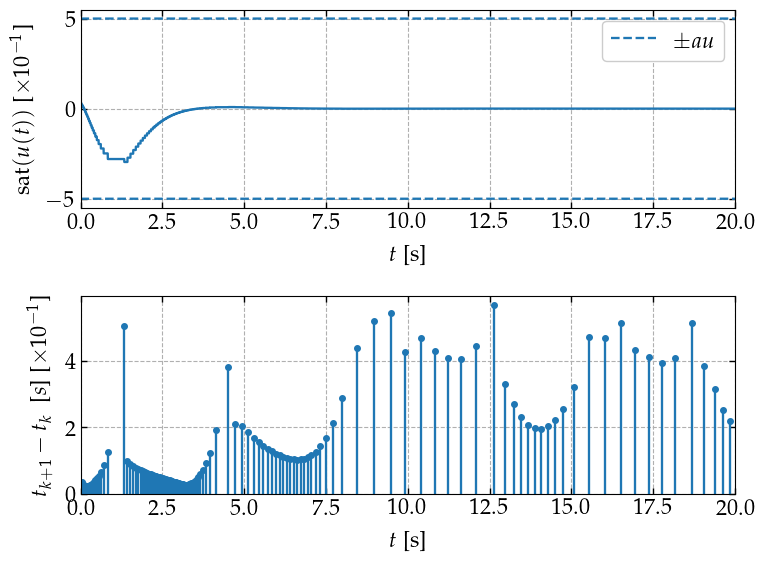

In [28]:
mosaic = [['control'], ['iet']]
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8, 6))

inter_event_time = DSPETC.get_iet(event_times)
u_bar = plant.get_input_bounds()

for i in range(plant.nu):
  y_multi = [control_signal[i] for i in range(plant.nu)] + [
      [u_bar[i]] * len(t),
      [-u_bar[i]] * len(t)
  ]

  gph.plot(
      axs['control'], t, y_multi, xlabel='$t$', x_unit='s', x_use_prefixes=True,
      ylabel=r'sat$(u(t))$', label=['', '', r'$\pm au$'], y_pad=(0.05, 0.05),
      cfg={**cfg, 'style': {'color': colors_list[0],
                            "linestyle": ["-", "--", "--"], }},)


gph.stem(
    axs['iet'], event_times, inter_event_time,
    reuse_previous=False, y_pad=(0.0, 0.05), x_use_prefixes=True,
    xlabel='$t$', x_unit='s', x_range=(0.0, t[-1]),
    ylabel='$t_{k+1} - t_k\\;$ [$s$]',
    cfg={**cfg, 'limits': {'x_min': 0,
                           'x_max': t[-1]}, 'style': {'color': colors_list[0]}})

plt.tight_layout(pad=2.)

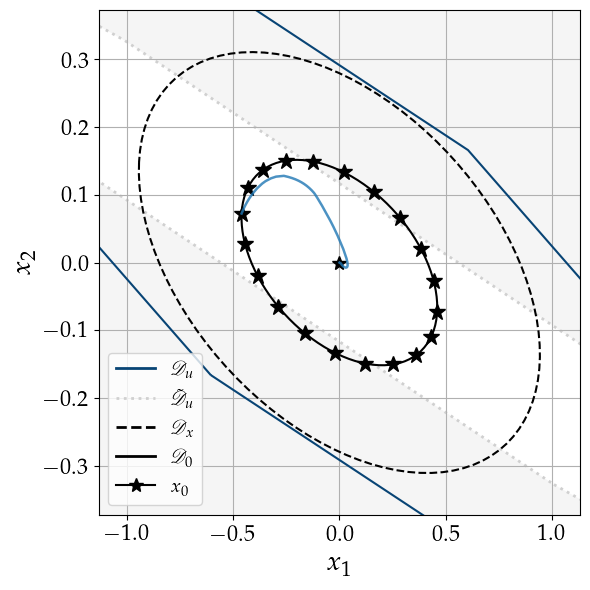

In [29]:
%%skip plant.nx != 2

traj_list = [x.T for (_, x, _, _, _, _) in all_results]
plot_regions_comparison(plant, nm, gph, K, L1, P, δinv, γ,
                        zoom_only=True, trajectories=traj_list)